In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [4]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Cargo el modelo y los datos a los que lo voy a aplicar 

In [6]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [7]:
import os
import joblib
# load model
#modelo = joblib.load("Analytics/5.Fraud/ModeloV1Todos.pkl") 
modelo = joblib.load("ModeloFinal2.pkl") 
variables = open('./ModeloFinal2.txt','r')
##ModeloV1T1

In [8]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

# Veo si puedo sacar los nombres directo del modelo q cargue


In [9]:
#variables = open('./ModeloFinal2.txt','r')
#var_input = variables.read()

In [10]:
var_input = ['01_branch_working_days', 'branch_minutes_since_last_transaction',
    'branch_trans_3m', 'branch_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist',
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count','01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [11]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [12]:
testeo[var_input]

,01_branch_working_days,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,0.052826,131.0,2659.0,0,1,1,1,0,2.0,0,True,True,1.000000,False,False,False,True,False,0,0.029703,0.635714,0.052826,0.216606,0.000000,0.172603,0.300000,0.583333
1,0.119738,109.0,1115.0,0,1,1,1,0,17.0,0,False,True,0.731183,False,False,False,True,False,0,0.108911,0.183929,0.119738,0.021661,0.000000,0.016438,0.028571,0.666667
2,0.337246,933.0,877.0,0,1,1,1,0,5.0,0,False,True,0.390625,False,False,False,True,False,0,0.009901,0.123214,0.337246,0.009025,0.000000,0.030137,0.052381,0.541667
3,0.287942,5.0,4494.0,0,2,2,2,0,12.0,0,False,True,2.432432,False,False,False,True,False,0,0.435644,0.733929,0.287942,0.162455,0.000000,0.021918,0.038095,0.375000
4,0.234781,56.0,751.0,0,1,1,1,0,2.0,0,True,True,1.000000,False,False,False,True,False,0,0.029703,0.837500,0.234781,0.722022,0.000000,0.161644,0.280952,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16724863,0.039074,3.0,942.0,0,5,2,5,0,1.0,0,True,False,1.000000,False,False,False,True,False,0,0.019802,NaN,0.039074,0.036101,0.000000,NaN,NaN,0.541667
16724864,0.239980,60.0,2028.0,0,1,1,1,0,8.0,0,False,True,1.015873,False,False,False,True,False,0,0.504950,0.987500,0.239980,0.144404,0.000000,0.019178,0.033333,0.500000
16724865,0.500252,0.0,10118.0,0,9,3,8,0,8.0,0,False,True,1.484117,False,False,False,True,False,0,0.138614,0.212500,0.500252,0.105415,0.000000,0.019178,0.033333,0.750000
16724866,0.132316,126.0,3154.0,0,1,1,1,0,3.0,0,True,True,1.014085,False,False,False,True,False,0,0.128713,0.617857,0.132316,0.043321,0.000000,0.035616,0.061905,0.541667


In [13]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')


In [14]:
#saco el punto de corte del primer centil para aplicarlo al test
corte2 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()

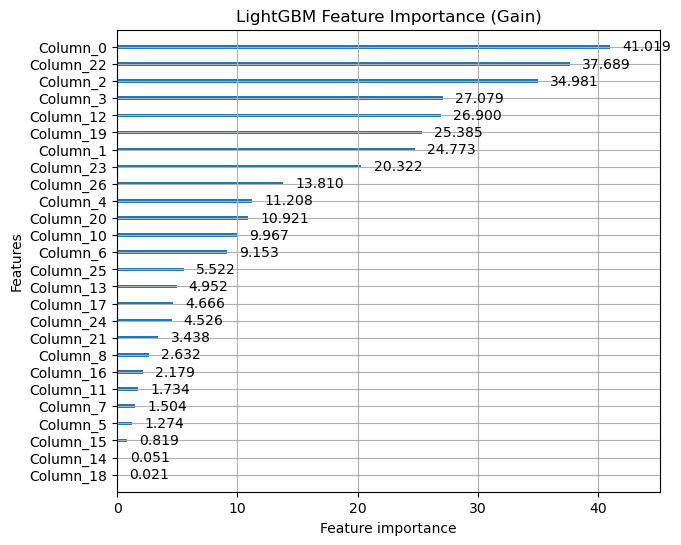

In [15]:
import lightgbm as lgb
lgb.plot_importance(modelo, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

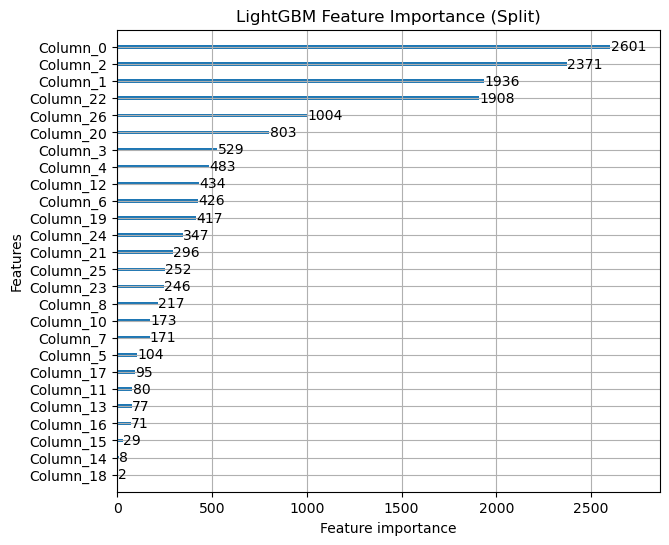

In [16]:
# Plot feature importance using Split
lgb.plot_importance(modelo, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [17]:
# Save feature importance in text file
# Importance is measured in terms of gain according to LightGBM classifier
#np.savetxt('./ModeloFinalImp2.txt', modelo.booster_.feature_importance(importance_type='split'),fmt='%f')
#np.savetxt('./ModeloFinalImpG2.txt', modelo.booster_.feature_importance(importance_type='gain'),fmt='%f')

In [18]:
#Pongo el archivo q quiero testear
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")

##lista de variables de input
X = tes[var_input]
Y = tes[['target']]

#testeo = pd.concat([testeo, tes], axis = 0, ignore_index=True)
#Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target], tes[dias_target]], ignore_index=True)) 
testeo =  tes.copy()
Y_target = pd.DataFrame(tes[dias_target]) 

In [19]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [20]:
testeo['target'].value_counts(dropna=False)

target
False    6837338
True          62
Name: count, dtype: int64

In [21]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [22]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [23]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,6837331,7
1,55,7


In [24]:
corte

1.1511944114690123e-06

In [65]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,6813568,23770
1,27,35


In [26]:
#import seaborn as sns
#sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [66]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA .04%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA .04%:
0.5483870967741935


In [67]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,6815,23
2,6832,5
3,6832,6
4,6833,4
5,6835,2
...,...,...
996,6837,0
997,6837,0
998,6838,0


In [68]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf                       
                                min                    max
FRAUD_DECILE                                              
1            0.00001204421075605172 0.97279097287063198696
2            0.00000337866386019636 0.00001203361295643661
3            0.00000154034439899924 0.00000337834200206408
4            0.00000085923706237693 0.00000154028844156464
5            0.00000054494810126111 0.00000085922330734183
...                             ...                    ...
996          0.00000000000016431325 0.00000000000018853135
997          0.00000000000013894114 0.00000000000016430450
998          0.00000000000010976505 0.00000000000013893993
999          0.00000000000007498465 0.00000000000010976179
1000         0.00000000000000209287 0.00000000000007498085

[1000 rows x 2 columns]

In [69]:
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]
pd.crosstab(tes_corte['date_receiver'].dt.month, Y_c_corte['target'])
#pd.crosstab(testeo['date_receiver'].dt.month, Y_c['target'])

target,False,True
date_receiver,,
1,8539,20
2,7902,7
3,7329,8


In [31]:
tes_corte.to_csv ('./Corte.csv')

In [70]:
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,951,887,826,949,1146,1123,956
2,1000,852,794,830,1096,1269,996
3,959,895,838,846,1137,1171,992
4,950,906,798,860,1146,1224,953
5,972,882,814,822,1164,1210,973
6,923,841,788,821,1182,1233,1050
7,928,821,735,856,1161,1289,1047
8,929,862,759,843,1086,1298,1061
9,956,826,796,823,1150,1256,1030


In [33]:
#DECILES.to_csv ('./deciles.csv')

# Buckets para codificar Score

In [71]:
 Y_c['FRAUD_DECILE'].value_counts()

FRAUD_DECILE
27     6840
712    6839
409    6839
329    6839
524    6839
       ... 
801    6836
545    6836
345    6836
26     6836
992    6836
Name: count, Length: 1000, dtype: Int64

In [72]:
#Guardo los puntos de corte para recodificar el score
pd.options.display.float_format = "{:,.20f}".format
Buckets = Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}).stack(0, future_stack=True)
Buckets = Buckets.reset_index()
Buckets['final_score'] = 1-(Buckets['FRAUD_DECILE']/1000)
Buckets[['FRAUD_DECILE','min','max','final_score']].to_csv ('./Buckets.csv')

Y_c['score_rf2'] = 0
Y_c['score_rf2'] = Y_c['score_rf2'].astype(str) 
for i in range(Y_c.shape[0]):
    a = Buckets.loc[(Y_c.loc[i,'score_rf'] <= Buckets['max']) & (Y_c.loc[i,'score_rf'] >= Buckets['min']), 'final_score'] 
    Y_c.loc[i,'score_rf2'] = a.item()

In [36]:
#Y_c.loc[1,['score_rf2','FRAUD_DECILE']] 

In [73]:
Y_c.iloc[1]

day_name_receiver_0                    False
day_name_receiver_1                    False
day_name_receiver_2                    False
day_name_receiver_3                    False
day_name_receiver_4                     True
day_name_receiver_5                    False
day_name_receiver_6                    False
target                                 False
preds_rf                               False
score_rf              0.00000000021624381689
pred_corte                             False
FRAUD_DECILE                             184
Name: 1, dtype: object

In [74]:
Buckets[Buckets['FRAUD_DECILE']==644]

,FRAUD_DECILE,level_1,min,max,final_score
643,644,score_rf,0.00000000000942686624,0.00000000000947600766,0.35599999999999998312


## Curva ROC y FP

In [39]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [40]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [41]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [42]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['preds_rf'])
recall = recall_score(Y_c[['target']], Y_c['preds_rf'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
8.870954767771668
ROC FRAUD TESTEO:
0.5564511010080994


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.8173069458771348
Precision FRAUD TESTEO:
0.5
Recall FRAUD TESTEO:
0.11290322580645161


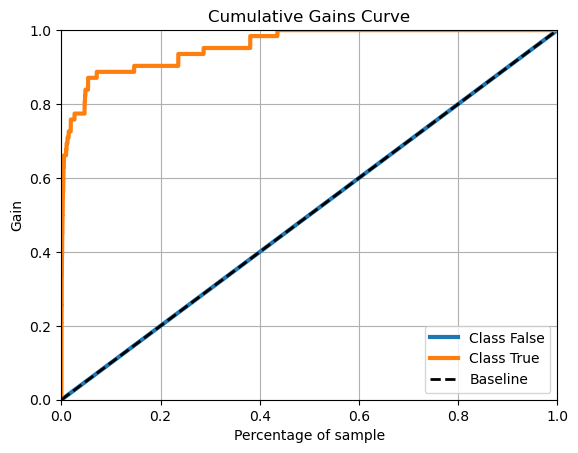

In [43]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


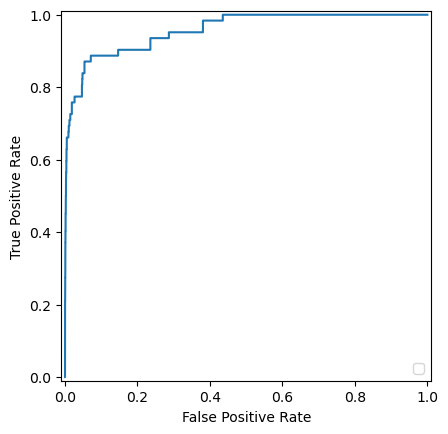

In [44]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

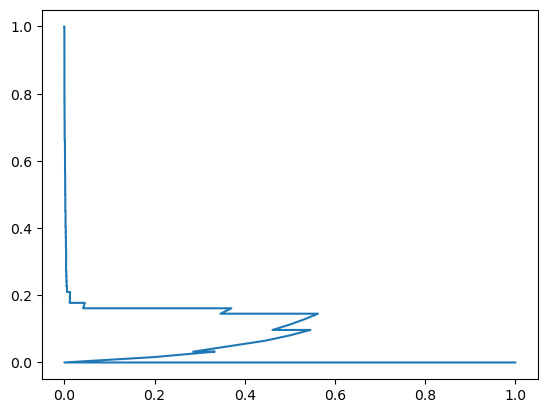

In [45]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(precision, recall)

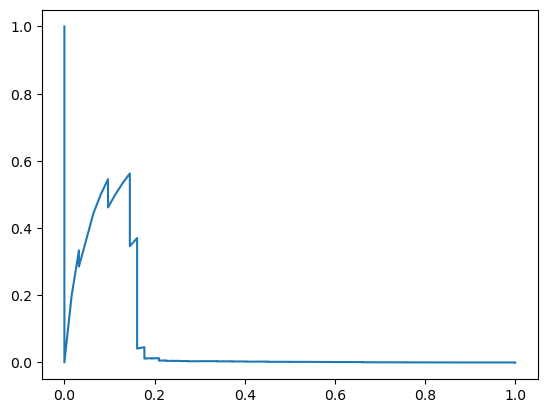

In [46]:
plt.plot(recall, precision)

## One given week

In [47]:
tes[tes['target']==True].head()

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
231933,A25718,47,2024-01-24 18:24:18.070,NY1546,NN,11306118,"1,500.00000000000000000000",1.00000000000000000000,MEX,MEX25,NY,65,NaN,NaN,USA,Real,NaN,8.00000000000000000000,0,40,CA,2,0,3,2,0,2,1,"1,500.00000000000000000000",0,1,18,True,False,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.01331311088641725683,0.54840195669818159185,NaN,NaN,NaN,NaN,0.75000000000000000000,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
269827,A25718,46,2024-01-24 18:16:31.533,NY1546,NN,10303412,"1,500.00000000000000000000",1.00000000000000000000,MEX,MEX33,NY,65,210.00000000000000000000,34.00000000000000000000,USA,Real,"49,208.00000000000000000000",9.00000000000000000000,0,39,CA,1,1,2,2,0,1,2,"1,700.00000000000000000000",1,1,18,True,False,0.88235294117647056211,True,True,True,True,False,True,34.00000000000000000000,0,34.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.29329608938547485630,0.01331311088641725683,0.54840195669818159185,0.00000000000000000000,0.00000000000000000000,0.09315068493150685525,0.16190476190476191243,0.75000000000000000000,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
308307,A22792,11766,2024-01-19 17:47:25.867,NV0185,NN,11283276,980.00000000000000000000,1.00000000000000000000,MEX,MEX27,NV,583,NaN,NaN,USA,Real,NaN,30.00000000000000000000,0,2475,NV,3,0,1,1,0,3,1,980.00000000000000000000,0,1,17,True,True,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.10060667340748230547,0.35828927837614527041,NaN,NaN,NaN,NaN,0.70833333333333337034,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
468554,A25581,183,2024-01-07 19:55:34.963,SC0729,NN,11235795,980.00000000000000000000,1.00000000000000000000,MEX,MEX44,SC,66,NaN,NaN,USA,Real,NaN,28.00000000000000000000,0,173,SC,3,0,2,1,0,3,1,980.00000000000000000000,0,1,19,True,True,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.01348163127738456410,0.35828927837614527041,NaN,NaN,NaN,NaN,0.79166666666666662966,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,True
4

In [48]:
week_testigo = tes['date_receiver'].between('2024-01-01','2024-01-30')
X_week_testigo = tes[week_testigo]
Y_c_week_testigo = Y_c[week_testigo]

week_testigo.sum(), X_week_testigo.shape, Y_c_week_testigo.shape

(1972832, (1972832, 77), (1972832, 12))

In [49]:
pd.crosstab(X_week_testigo['date_receiver'].dt.day, Y_c_week_testigo['target'])

target,False,True
date_receiver,,
1,14877,0
2,64369,0
3,53021,0
4,53556,0
5,82215,1
6,89445,0
7,75931,6
8,64412,0
9,49193,0


In [75]:
#Veo cuantos falsos positivos tengo con el punto de corte
X_week_testigo_corte = X_week_testigo[Y_c_week_testigo['pred_corte']==True]
Y_c_week_testigo_corte = Y_c_week_testigo[Y_c_week_testigo['pred_corte']==True]

pd.crosstab(X_week_testigo_corte['date_receiver'].dt.day, Y_c_week_testigo_corte['target'])

target,False,True
date_receiver,,
1,209,0
2,800,0
3,682,0
4,704,0
5,990,0
6,909,0
7,765,6
8,838,0
9,674,0


In [76]:
Tabla_Week = pd.DataFrame(pd.concat([X_week_testigo['date_receiver'].dt.day,X_week_testigo['fraud_classification'], 
                                     Y_c_week_testigo['FRAUD_DECILE'], Y_c_week_testigo['target']],axis=1))

In [52]:
Tabla_Week[Tabla_Week['target']==True]
pd.crosstab(Tabla_Week.date_receiver, Tabla_Week.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,...,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000
date_receiver,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,17,24,13,21,16,25,21,15,18,24,17,18,33,18,29,20,29,21,27,16,18,18,17,14,21,20,26,30,27,18,26,22,23,20,21,16,32,33,22,15,15,23,15,18,19,15,10,12,24,20,19,22,20,18,15,15,19,14,20,25,22,26,21,17,22,15,12,16,17,24,21,16,16,19,27,26,23,19,21,18,20,21,25,23,21,19,16,20,21,15,21,29,19,27,19,17,21,16,20,18,10,24,26,16,30,11,23,15,20,16,20,25,20,19,29,21,26,24,27,16,13,23,14,15,17,14,20,20,20,22,19,23,26,13,19,31,21,17,19,19,23,15,16,23,20,26,18,18,20,7,14,13,18,23,25,20,15,19,16,21,23,18,25,19,26,16,20,22,15,22,17,25,23,16,16,17,9,26,28,15,18,12,21,18,18,15,15,17,16,13,13,16,24,12,21,18,25,22,15,19,12,21,13,11,15,15,16,19,12,18,20,24,15,13,15,8,16,14,10,13,15,20,19,13,20,17,27,15,16,11,15,10,12,17,13,15,18,23,14,21,14,20,16,14,17,14,11,16,20,22,...,7,13,16,6,14,4,8,9,10,10,11,16,10,18,13,11,6,15,10,10,14,14,11,11,16,10,13,18,14,14,14,11,14,19,12,15,13,8,13,12,12,13,11,17,8,16,15,19,9,16,14,14,6,13,14,11,12,13,9,12,15,16,14,8,11,7,16,3,9,7,5,14,14,15,11,18,16,10,8,19,8,12,9,10,7,11,11,6,16,18,10,17,2,8,8,9,19,21,11,7,12,14,9,9,11,9,13,11,9,13,7,18,6,16,13,13,8,10,10,14,17,7,14,9,8,12,9,12,6,15,11,14,13,7,11,16,5,14,5,10,10,8,13,10,14,14,12,7,12,10,3,9,14,8,9,7,17,16,12,14,9,13,10,5,12,13,8,12,8,9,17,5,10,9,12,8,19,12,12,9,10,11,10,8,12,11,9,15,9,13,8,7,15,6,10,9,11,12,10,9,6,7,4,9,14,11,10,12,7,12,7,6,13,8,10,9,12,12,19,13,4,6,8,6,10,7,11,8,9,7,8,12,2,10,8,13,8,15,8,3,10,6,5,9,6,8,8,5,8,9
2,69,63,65,78,75,68,85,79,80,82,85,78,91,83,97,80,92,87,79,103,70,84,79,74,84,69,89,74,74,81,100,91,99,91,81,98,79,75,80,97,74,76,88,81,90,108,90,103,96,84,68,91,105,82,8

In [53]:

pd.crosstab(Tabla_Week.date_receiver[Tabla_Week['target']==True], Tabla_Week.FRAUD_DECILE[Tabla_Week['target']==True])

FRAUD_DECILE,1,2,3,4,15,27,436
date_receiver,,,,,,,
5,0,0,0,0,0,0,1
7,5,0,0,1,0,0,0
14,1,0,1,0,0,1,0
19,2,1,1,0,1,0,0
21,3,0,1,0,0,0,0
24,3,0,0,0,0,0,0


In [54]:
Tabla_Week.loc[Tabla_Week['target']==True,['date_receiver','fraud_classification','FRAUD_DECILE']]

,date_receiver,fraud_classification,FRAUD_DECILE
231933,24,Real,1
269827,24,Real,1
308307,19,Real,2
468554,7,Real,1
475176,5,Real,436
507041,24,Real,1
522317,21,Real,1
526070,14,Real,27
675600,21,Real,1
712534,21,Real,3


# Analisis extra por cantidad FP

In [55]:
testeo.loc[(testeo['id_receiver'] ==30890) & (testeo['id_branch'] =='A14536')] 
#testeo['id_branch'] =='A14536'

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
4870507,A14536,30890,2024-03-20 12:42:15.783,MA0108,NN,5717054,"1,050.50000000000000000000",28.00000000000000000000,BRA,BRA2,MA,2751,888.00000000000000000000,35.00000000000000000000,USA,None,"50,478.00000000000000000000",24.00000000000000000000,0,1116,MA,0,0,2,1,0,0,4,"2,492.06999999999970896170",0,3,12,False,True,0.42153711573109908795,False,False,False,False,False,True,35.00000000000000000000,0,35.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.28421052631578946901,1.00000000000000000000,0.46595888102460397695,0.38406417034095979846,0.00000000000000000000,0.00000000000000000000,0.09589041095890410427,0.16666666666666665741,0.50000000000000000000,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date_receiver', ylabel='Count'>

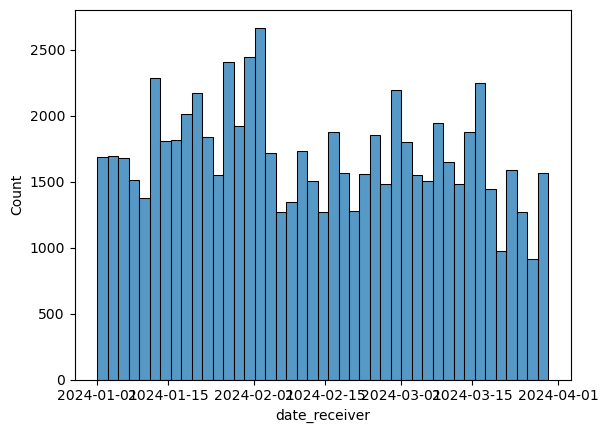

In [56]:
import seaborn as sns
sns.histplot(data = tes_corte['date_receiver'].dt.floor('d'))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date_receiver', ylabel='Count'>

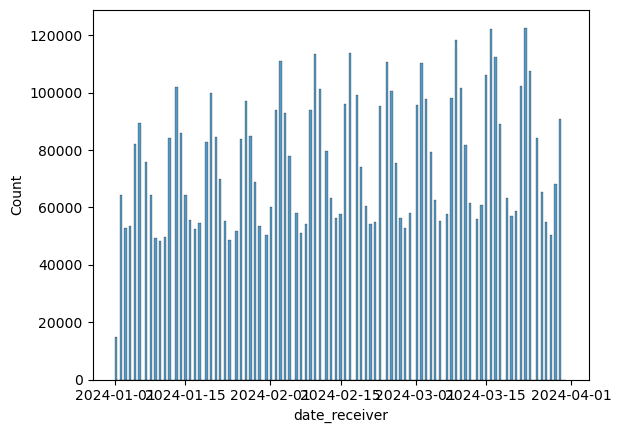

In [57]:
sns.histplot(data = testeo['date_receiver'].dt.floor('d'))

In [58]:

Alertas_2024 = pd.crosstab(tes_corte['date_receiver'].dt.floor('d'), Y_c_corte['target'])
Alertas_2024.to_csv ('./alertas2024.csv')

In [59]:
testeo[testeo['mes']==1].describe()

,id_receiver,date_receiver,id_sender_global,net_amount_receiver,receiver_transaction_count,branch_working_days,sender_sending_days,sender_days_to_last_transaction,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_var_range_hist,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
count,"2,076,906.00000000000000000000",2076906,"2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","2,076,874.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000"
mean,"67,332.80096403014613315463",2024-01-17 03:25:09.707793152,"8,267,104.98367908783257007599",457.34215281105622352698,1.01808555611086881676,"1,599.41525134021480880619",555.94958481402181860176,30.71975416800350089375,"44,240.69602518725150730461",111.74940993050131510245,0.00000000000000000000,"3,671.45134348882402264280",0.09055296676883788087,0.01347774044660663556,4.14846555405011141460,1.91383047668021566423,2.69588031427517682559,0.09084282100393566151,8.39999065918245690909,461.67398417969280899342,0.00008377846662294778,1.00000000000000000000,15.26093381212245603251,0.98341650062590824088,23.58870987014347164745,0.01139531591704198536,19.65989884624517358702,0.02492601976208841386,94.08835013212427611506,24.80822175522662575986,0.00019037427485125020,0.63292275709399026251,0.27129709832035037165,0.16425209527904952034,0.03266956601809870020,0.01722793177446295051,0.06462660238395470658,0.09361856593450078312,0.63587224217176885332
min,1.00000000000000000000,2024-01-01 03:00:23.573000,9.00000000000000000000,0.00000000000000000000,1.00000000000000000000,-19.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,1.00000000000000000000,3.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000

In [60]:
testeo[testeo['mes']==3].describe()

,id_receiver,date_receiver,id_sender_global,net_amount_receiver,receiver_transaction_count,branch_working_days,sender_sending_days,sender_days_to_last_transaction,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_var_range_hist,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
count,"2,493,885.00000000000000000000",2493885,"2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,488,376.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000"
mean,"67,147.78369291286799125373",2024-03-15 19:30:47.806508544,"8,397,131.44546440616250038147",440.77123431790164431732,14.01989386038249563171,"1,585.12772240901244913402",578.95790993637422161555,33.05045768722315813193,"47,598.26427709477866301313",96.54369596877641868105,0.00000000000000000000,"3,485.99444360906772999442",0.08959795660184811938,0.01594139264641312656,4.45229310894447838365,2.00665868714876571843,2.91195544301361142203,0.08983573821567554518,7.95960038253568225031,438.92972999902144692896,0.00008500792939530091,3.00000000000000000000,15.48751526233166408986,1.00616651224200026604,24.07418810623104832302,0.01389719253293556119,19.86344083714932295948,0.02840146999560926033,99.13195137575357307469,26.57468169255313483745,0.13316021092856278329,0.64363202833923516266,0.26877491640136536022,0.15867546247265090775,0.03442081644991443895,0.01845464006427301878,0.06595667974309876724,0.09458781351023486106,0.64531313593048655886
min,1.00000000000000000000,2024-03-01 03:00:17.187000,9.00000000000000000000,0.73999999999999999112,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.91266666666666662611,0.00000000000000000000,3.00000000000000000000,3.00000000000000000000,0.00066489067717885424,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00235928547354229872,0

for var in var_input:
    sns.histplot(data = tes_corte, x=var, hue = 'mes')
    plt.show()

In [61]:
week_fraude = tes['date_receiver'].between('2024-02-02','2024-02-11')
X_fraude = tes[week_fraude]
Y_c_fraude = Y_c[week_fraude]
Y_c_fraude

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,target,preds_rf,score_rf,pred_corte,FRAUD_DECILE
2076908,True,False,False,False,False,False,False,False,False,0.00000000006138152144,False,320
2076911,False,False,False,False,False,True,False,False,False,0.00000000031615207798,False,155
2076919,False,True,False,False,False,False,False,False,False,0.00000000167560704602,False,73
2076921,False,False,False,False,True,False,False,False,False,0.00000000032374146388,False,154
2076924,False,False,False,False,False,False,True,False,False,0.00000000000254213302,False,861
...,...,...,...,...,...,...,...,...,...,...,...,...
4343493,False,False,False,False,True,False,False,False,False,0.00000000000693795639,False,702
4343494,False,True,False,False,False,False,False,False,False,0.00000000001180147712,False,602
4343496,False,False,False,False,False,True,False,False,False,0.00000000000134092934,False,927
4343503,False,False,False,False,False,False,True,False,False,0.00000000001528872172,False,552


In [62]:
week_fraude = tes['date_receiver'].between('2024-03-21','2024-03-22')
X_fraude = tes[week_fraude]
Y_c_fraude = Y_c[week_fraude]
X_fraude[Y_c_fraude['pred_corte']==True].sort_values(by=['id_branch'])

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
4616301,A00047,13384431,2024-03-21 18:52:14.027,AK0004,NN,4658877,"5,300.00000000000000000000",44.00000000000000000000,IND,IN36,AK,1298,"1,157.00000000000000000000",2.00000000000000000000,USA,None,"2,880.00000000000000000000",0.00000000000000000000,0,699,KS,0,0,9,9,0,0,6,"1,000.33333333333337122895",0,3,18,False,False,5.29823392202599130485,False,False,False,False,False,True,2.00000000000000000000,0,2.00000000000000000000,0,"2,880.00000000000000000000",0.00000000000000000000,0.45263157894736844034,1.00000000000000000000,0.22109875294910683041,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00547945205479452059,0.00952380952380952467,0.75000000000000000000,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4935791,A00865,4745,2024-03-21 13:23:29.883,CO0131,NN,11576017,450.00000000000000000000,1.00000000000000000000,MEX,MEX45,CO,3838,NaN,NaN,USA,None,NaN,"1,033.00000000000000000000",0,239,CO,0,0,1,1,1,0,1,450.00000000000000000000,0,3,13,True,True,1.00000000000000000000,False,False,False,False,True,False,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.64914054600606674317,0.16452058700945446090,NaN,NaN,NaN,NaN,0.54166666666666662966,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
6213340,A02374,97992,2024-03-21 10:35:16.987,SC0110,NN,2621012,490.00000000000000000000,1.00000000000000000000,MEX,MEX33,SC,5955,NaN,NaN,USA,None,NaN,154.00000000000000000000,0,1331,SC,0,0,1,1,1,0,1,490.00000000000000000000,0,3,10,True,True,1.00000000000000000000,False,False,False,False,True,False,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,1.00000000000000000000,0.17914463918807263521,NaN,NaN,NaN,NaN,0.41666666666666668517,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
5501071,A02399,139246,2024-03-21 19:13:21.230,IL0233,NN,11578092,"1,000.00000000000000000000",1.00000000000000000000,MEX,MEX7,IL,5937,NaN,NaN,USA,None,NaN,16.00000000000000000000,0,2755,IL,0,0,3,1,2,0,1,"1,000.00000000000000000000",0,3,19,True,True,1.00000000000000000000,False,False,False,False,True,False,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,1.00000000000000000000,0.36560130446545435756,NaN,NaN,NaN,NaN,0.79166666666666662966,False,False,False,True,False,False,False,False,False,False,False,False,F

In [63]:
#Y_c[tes['id_barnch'].str.contains('A24793')].sort_values(by=['id_receiver'])
testeo.loc[(testeo['id_receiver'] ==5619) & (testeo['id_branch'] =='A24793')] 

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target


In [64]:

pd.crosstab(testeo.loc[Y_c['target']==True,'date_receiver'], Y_c.loc[Y_c['target']==True,'pred_corte'])


pred_corte,False,True
date_receiver,,
2024-01-05 15:45:55.033,1,0
2024-01-07 18:52:26.650,0,1
2024-01-07 19:07:52.540,0,2
2024-01-07 19:27:44.750,0,1
2024-01-07 19:55:34.963,0,1
2024-01-07 20:11:15.780,0,1
2024-01-14 15:09:23.963,1,0
2024-01-14 15:27:10.183,0,1
2024-01-14 16:29:44.087,0,1
